### EDA

In [55]:
import mmcv
from mmcv import Config
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)
from mmdet.models import build_detector
from mmdet.apis import single_gpu_test
from mmcv.runner import load_checkpoint
import os
from mmcv.parallel import MMDataParallel
import pandas as pd
from pandas import DataFrame
from pycocotools.coco import COCO 
import numpy as np

In [56]:
import matplotlib.pyplot as plt 
import cv2

In [57]:
COLORS = [
    (204,24,30),
    (39,147,232),
    (85,153,0),
    (102,102,102),
    (27,133,184),
    (90,82,85),
    (85,158,131),
    (174,90,65),
    (195,203,113),
    (243,119,54),
    (184,167,234)
]

In [151]:
import pandas as pd
res = pd.read_csv("submission.csv")

In [152]:
def split_values(d):
    d_lst = d.split(' ')
    re = []
    for i in range(0,len(d_lst),6):
        re.append(d_lst[i:i+6])
    return re[:-1]
output = [np.asarray(split_values(res.PredictionString.values[i])) for i in range(len(res))]

In [153]:
# Felzenszwalb et al
def non_max_suppression_fast(boxes, scores, iou_threshold):
    
    '''
        boxes : coordinates of each box
        scores : score of each box
        iou_threshold : iou threshold(box with iou larger than threshold will be removed)
    '''
    
    if len(boxes) == 0:
        return []

    # Init the picked box info
    pick = []

    # Box coordinate consist of left top and right bottom
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,0] + boxes[:,2]
    y2 = boxes[:,1] + boxes[:,3]

    # Compute area of each boxes
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    # Greedily select the order of box to compare iou
    idxs = np.argsort(scores)

    while(len(idxs) > 0):
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # With vector implementation, we can calculate fast
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        intersection = w * h

        # Calculate the iou
        iou = intersection / (area[idxs[:last]] + area[idxs[last]] - intersection)

        idxs = np.delete(idxs, np.concatenate(([last], np.where(iou > iou_threshold)[0])))

    return boxes[pick].astype("int")

idx = 54
def draw_result(idx):
    out = output[idx]
    coco = COCO(annotation_file='../input/data/test.json')
    data_dir = '../input/data/'
    idx = coco.getImgIds(idx)
    img = cv2.imread(data_dir+coco.load_imgs(idx)[0]['file_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pred_img = img.copy()
    
    for bbox in out:
#         print(c)
        c = int(bbox[0])
        bbox = bbox[1:]
        score = str(bbox[0])[:5]
#         print(c,score)
        x1,y1,x2,y2 = bbox[1:].astype('float64').astype('int64')
        pred_img = cv2.rectangle(pred_img, (x1,y1), (x2,y2), COLORS[c], 3 )
        text = coco.cats[c]['name'] + ":" + score
#         print(text)
        cv2.putText(pred_img, text, (x1+10,y1+19), cv2.FONT_HERSHEY_DUPLEX, 0.7, (0,0,0))
        
    plt.figure(figsize=(10,10))
    plt.imshow(pred_img)
    plt.show()

In [12]:
output[0][:,2:].astype('int')

ValueError: invalid literal for int() with base 10: '173.22930908203125'

In [13]:
non_max_suppression_fast(output[0][:,2:].astype('int64'), output[0][:,1], 0.0006)

ValueError: invalid literal for int() with base 10: '173.22930908203125'

In [14]:
non_max_suppression_fast(output[0])

TypeError: non_max_suppression_fast() missing 2 required positional arguments: 'scores' and 'iou_threshold'

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


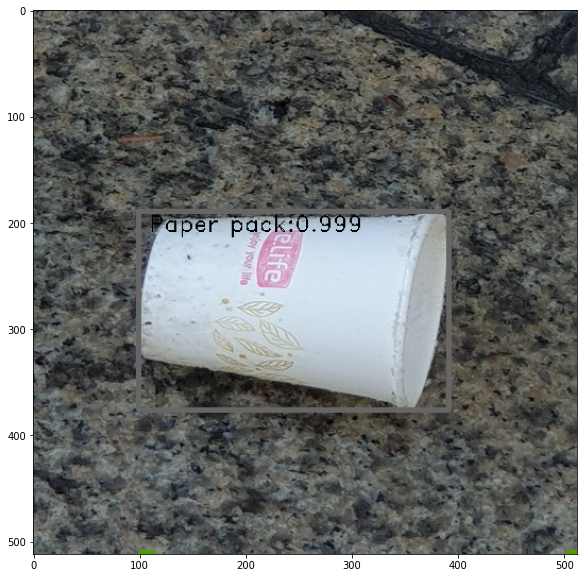

In [162]:
draw_result(80)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


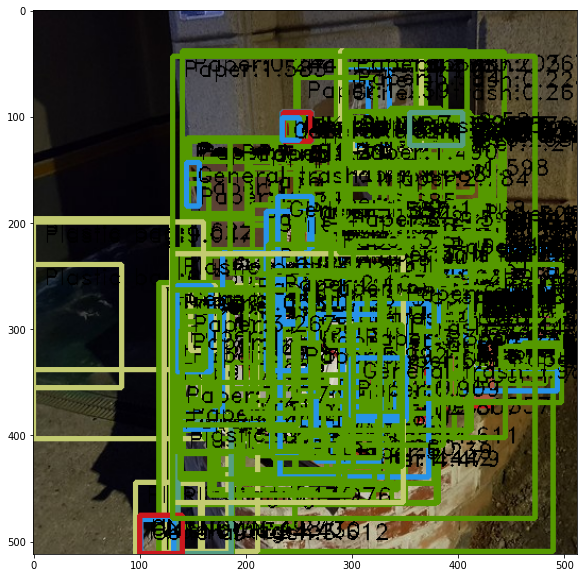

In [16]:
draw_result(200)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


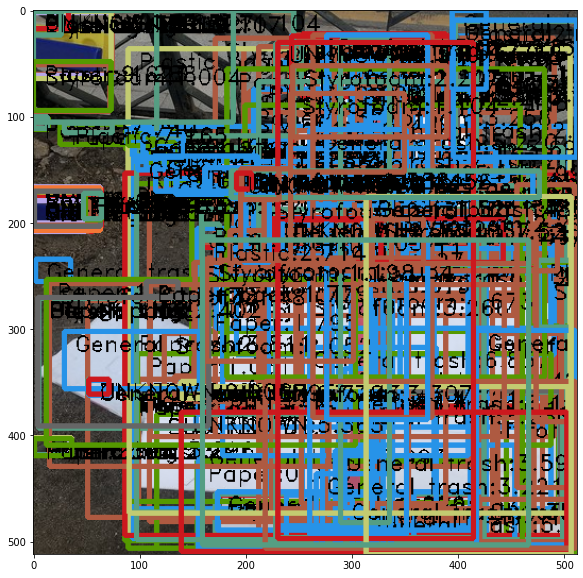

In [17]:
draw_result(100)